# Project Objectives

The objective of the project is to learn how to implement a simple image classification pipeline based on the k-Nearest 
Neighbour and a deep neural network. The goals of this assignment are as follows:

● Understand the basic Image Classification pipeline and the data-driven approach (train/predict stages)

● Data fetching and understand the train/val/test splits.

● Implement and apply an optimal k-Nearest Neighbor (kNN) classifier (7.5 points)

● Print the classification metric report (2.5 points)

● Implement and apply a deep neural network classifier including (feedforward neural network, RELU activations) (5 points)

● Understand and be able to implement (vectorized) backpropagation (cost stochastic gradient descent, cross entropy loss, cost functions) (2.5 points)

● Implement batch normalization for training the neural network (2.5 points)

● Understand the differences and trade-offs between traditional and NN classifiers with the help of classification metrics (5 points)

In [3]:
import os
import time
import math
import h5py
import numpy as np
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

tf.disable_v2_behavior()
tf.reset_default_graph()

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0) # Set default figure size

print("Tensorflow version", tf.__version__)

W0915 16:17:48.134065 18344 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\compat\v2_compat.py:65: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


Tensorflow version 2.0.0-rc1


In [20]:
np.seterr(over='ignore')
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"

#### Loading the data


In [76]:
# Open the file as readonly
h5f = h5py.File('./SVHN_single_grey1.h5', 'r')

# Load the training, test and validation set
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]
X_val = h5f['X_val'][:]
y_val = h5f['y_val'][:]

# Close this file
h5f.close()

print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_val.shape, y_val.shape)
print('Test set', X_test.shape, y_test.shape)

Training set (42000, 32, 32) (42000,)
Validation set (60000, 32, 32) (60000,)
Test set (18000, 32, 32) (18000,)


In [77]:
# Changing dimensions to N x D = 32x32
x_tr = []
for i in range(42000):
    x_tr.append(X_train[i,:].flatten())
    
x_val = []
for i in range(60000):
    x_val.append(X_val[i,:].flatten())

x_te = []
for i in range(18000):
    x_te.append(X_test[i,:].flatten())

In [78]:
print(len(x_tr),len(x_tr[0]))
print(len(x_val),len(x_val[0]))
print(len(x_te),len(x_te[0]))

42000 1024
60000 1024
18000 1024


# KNN

In [79]:
class KNN:
    def __init__(self):
        pass
    
    # Memorize the training data    
    def train(self, X, y):
        # X is 2D if size N x D = 28x28, so each row is an example
        # y is 1D of size N
        self.tr_x = X
        self.tr_y = y
        
    # For the test image:
    #  find nearest train image with minimum distance from the test image
    #  predict the label of nearest training image
    def predict(self, x):
        # x is of size D = 28x28 for which we want to predict the label
        # returns the predicted label for the input x
        min_idx = None
        min_dist = 100000000
        for test_sample in range(len(self.tr_x)):
            dist = 0
            for each_value in range(len(self.tr_x[0])):
                dist += abs(float((self.tr_x[test_sample][each_value] - x[each_value])))
            if dist < min_dist:
                min_dist = dist
                min_idx = test_sample
        return self.tr_y[min_idx] 

In [80]:
KNNclassifier = KNN()

In [81]:
KNNclassifier.train(x_tr, y_train)

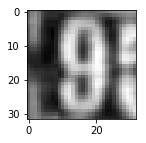

In [82]:
plt.figure(figsize=(2,2))
plt.imshow(X_test[3],cmap="gray")
plt.show()

In [83]:
print(KNNclassifier.predict(x_te[3]))

9


In [84]:
train_features = np.asarray(x_tr)
val_features = np.asarray(x_val)
test_features = np.asarray(x_te)

print(len(train_features),len(train_features[0]))
print(len(val_features),len(val_features[0]))
print(len(val_features),len(val_features[0]))

42000 1024
60000 1024
60000 1024


In [85]:
# # normalize inputs from 0-255 to 0-1
train_features = train_features / 255.0
test_features = test_features / 255.0

X_train = train_features
y_train = y_train

X_val = test_features
y_val = y_test

X_val1 = val_features
y_val1 = y_val

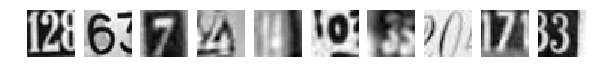

In [86]:
# visualizing the first 10 images in the dataset and their labels
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i].reshape(32, 32), cmap="gray")
    plt.axis('off')
plt.show()

#### Here, we define the container NN class that enables the forward prop and backward propagation of the entire network. Note, how this class enables us to add layers of different types and also correctly pass gradients using the chain rule.

#### Fully Connected Layer (Linear Layer)

In [87]:
import numpy as np 

class Linear():
    def __init__(self, in_size, out_size):
        self.W = np.random.randn(in_size, out_size) * 0.01
        self.b = np.zeros((1, out_size))
        self.params = [self.W, self.b]
        self.gradW = None
        self.gradB = None
        self.gradInput = None        

    def forward(self, X):
        self.X = X
        self.output = np.dot(X, self.W) + self.b
        return self.output

    def backward(self, nextgrad):
        self.gradW = np.dot(self.X.T, nextgrad)
        self.gradB = np.sum(nextgrad, axis=0)
        self.gradInput = np.dot(nextgrad, self.W.T)
        return self.gradInput, [self.gradW, self.gradB]

#### Rectified Linear Activation Layer (ReLU)


In [88]:
class ReLU():
    def __init__(self):
        self.params = []
        self.gradInput = None

    def forward(self, X):
        self.output = np.maximum(X, 0)
        return self.output

    def backward(self, nextgrad):
        self.gradInput = nextgrad.copy()
        self.gradInput[self.output <=0] = 0
        return self.gradInput, []

#### Defining the softmax function

In [89]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

#### Defining the Cross Entropy Loss

In [90]:
class CrossEntropy:
    def forward(self, X, y):
        self.m = y.shape[0]
        self.p = softmax(X)
        cross_entropy = -np.log(self.p[range(self.m), y]+1e-16)
        loss = np.sum(cross_entropy) / self.m
        return loss
    
    def backward(self, X, y):
        y_idx = y.argmax()        
        grad = softmax(X)
        grad[range(self.m), y] -= 1
        grad /= self.m
        return grad

In [91]:
class NN():
    def __init__(self, lossfunc=CrossEntropy(), mode='train'):
        self.params = []
        self.layers = []
        self.loss_func = lossfunc
        self.grads = []
        self.mode = mode
        
    def add_layer(self, layer):
        self.layers.append(layer)
        self.params.append(layer.params)

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward(self, nextgrad):
        self.clear_grad_param()
        for layer in reversed(self.layers):
            nextgrad, grad = layer.backward(nextgrad)
            self.grads.append(grad)
        return self.grads
    
    def train_step(self, X, y):
        out = self.forward(X)
        loss = self.loss_func.forward(out,y)
        nextgrad = self.loss_func.backward(out,y)
        grads = self.backward(nextgrad)
        return loss, grads
    
    def predict(self, X):
        X = self.forward(X)
        p = softmax(X)
        return np.argmax(p, axis=1)
    
    def predict_scores(self, X):
        X = self.forward(X)
        p = softmax(X)
        return p
    
    def clear_grad_param(self):
        self.grads = []

#### Defining the update function (SGD with momentum)


In [92]:
def update_params(velocity, params, grads, learning_rate=0.01, mu=0.9):
    for v, p, g, in zip(velocity, params, reversed(grads)):
        for i in range(len(g)):
            v[i] = mu * v[i] - learning_rate * g[i]
            p[i] += v[i]

In [93]:
# get minibatches
def minibatch(X, y, minibatch_size):
    n = X.shape[0]
    minibatches = []
    permutation = np.random.permutation(X.shape[0])
    X = X[permutation]
    y = y[permutation]
    
    for i in range(0, n , minibatch_size):
        X_batch = X[i:i + minibatch_size, :]
        y_batch = y[i:i + minibatch_size, ]
        minibatches.append((X_batch, y_batch))
        
    return minibatches

#### The traning loop

In [94]:
def train(net, X_train, y_train, minibatch_size, epoch, learning_rate, mu=0.9, X_val=None, y_val=None):
    val_loss_epoch = []
    minibatches = minibatch(X_train, y_train, minibatch_size)
    minibatches_val = minibatch(X_val, y_val, minibatch_size)

    
    for i in range(epoch):
        loss_batch = []
        val_loss_batch = []
        velocity = []
        for param_layer in net.params:
            p = [np.zeros_like(param) for param in list(param_layer)]
            velocity.append(p)
            
        # iterate over mini batches
        for X_mini, y_mini in minibatches:
            loss, grads = net.train_step(X_mini, y_mini)
            loss_batch.append(loss)
            update_params(velocity, net.params, grads, learning_rate=learning_rate, mu=mu)

        for X_mini_val, y_mini_val in minibatches_val:
            val_loss, _ = net.train_step(X_mini, y_mini)
            val_loss_batch.append(val_loss)
        
        # accuracy of model at end of epoch after all mini batch updates
        m_train = X_train.shape[0]
        m_val = X_val.shape[0]
        y_train_pred = np.array([], dtype="int64")
        y_val_pred = np.array([], dtype="int64")
        y_train1 = []
        y_vall = []
        for i in range(0, m_train, minibatch_size):
            X_tr = X_train[i:i + minibatch_size, : ]
            y_tr = y_train[i:i + minibatch_size,]
            y_train1 = np.append(y_train1, y_tr)
            y_train_pred = np.append(y_train_pred, net.predict(X_tr))

        for i in range(0, m_val, minibatch_size):
            X_va = X_val[i:i + minibatch_size, : ]
            y_va = y_val[i:i + minibatch_size,]
            y_vall = np.append(y_vall, y_va)
            y_val_pred = np.append(y_val_pred, net.predict(X_va))
            
        train_acc = check_accuracy(y_train1, y_train_pred)
        val_acc = check_accuracy(y_vall, y_val_pred)

        mean_train_loss = sum(loss_batch) / float(len(loss_batch))
        mean_val_loss = sum(val_loss_batch) / float(len(val_loss_batch))
        
        val_loss_epoch.append(mean_val_loss)
        print("Loss = {0} | Training Accuracy = {1} | Val Loss = {2} | Val Accuracy = {3}".format(mean_train_loss, train_acc, mean_val_loss, val_acc))
    return net

#### Checking the accuracy of the model 


In [95]:
def check_accuracy(y_true, y_pred):
    return np.mean(y_pred == y_true)

#### Invoking all that we have created until now

In [96]:
from random import shuffle

## input size
input_dim = X_train.shape[1]

## hyperparameters
iterations = 30
learning_rate = 1e4
hidden_nodes = 256
output_nodes = 10


In [97]:
## define neural net
nn = NN()
nn.add_layer(Linear(input_dim, hidden_nodes))
nn.add_layer(ReLU())
nn.add_layer(Linear(hidden_nodes, output_nodes))

nn = train(nn, X_train , y_train, minibatch_size=500, epoch=10, \
           learning_rate=learning_rate, X_val=X_val, y_val=y_val)

Loss = 32.808236721228155 | Training Accuracy = 0.0998095238095238 | Val Loss = 33.304590785065876 | Val Accuracy = 0.10044444444444445
Loss = 32.95827548310881 | Training Accuracy = 0.10076190476190476 | Val Loss = 33.15722533911426 | Val Accuracy = 0.09822222222222222
Loss = 33.14431435805827 | Training Accuracy = 0.10076190476190476 | Val Loss = 33.15722533911426 | Val Accuracy = 0.09822222222222222
Loss = 33.04887709498858 | Training Accuracy = 0.09923809523809524 | Val Loss = 33.15722533911426 | Val Accuracy = 0.10177777777777777
Loss = 33.09056001832663 | Training Accuracy = 0.09933333333333333 | Val Loss = 32.715129001259385 | Val Accuracy = 0.10155555555555555
Loss = 33.16775144239652 | Training Accuracy = 0.09933333333333333 | Val Loss = 32.715129001259385 | Val Accuracy = 0.10155555555555555
Loss = 33.129499349275754 | Training Accuracy = 0.10192857142857142 | Val Loss = 33.08354261613843 | Val Accuracy = 0.0955
Loss = 33.15234194970246 | Training Accuracy = 0.099809523809523

# Keras

In [122]:
# Open the file as readonly
h5f = h5py.File('./SVHN_single_grey1.h5', 'r')

# Load the training, test and validation set
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]
X_val = h5f['X_val'][:]
y_val = h5f['y_val'][:]

# Close this file
h5f.close()

print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_val.shape, y_val.shape)
print('Test set', X_test.shape, y_test.shape)

Training set (42000, 32, 32) (42000,)
Validation set (60000, 32, 32) (60000,)
Test set (18000, 32, 32) (18000,)


### Convert Output label to multiple values

In [147]:
trainY = tf.keras.utils.to_categorical(y_train, num_classes=10)
testY = tf.keras.utils.to_categorical(y_test, num_classes=10)

## Build the Graph

In [148]:
#Initialize Sequential model
model = tf.keras.models.Sequential()

#Reshape data from 2D to 1D -> 32x32 to 1024
model.add(tf.keras.layers.Reshape((1024,),input_shape=(32,32,)))

#Normalize the data
model.add(tf.keras.layers.BatchNormalization())

## Build the Graph...

In [165]:
#Add 1st hidden layer
model.add(tf.keras.layers.Dense(200, activation='sigmoid'))

In [166]:
#Add 2nd hidden layer
model.add(tf.keras.layers.Dense(100, activation='sigmoid'))

In [167]:
#Add 3rd hidden layer
model.add(tf.keras.layers.Dense(60, activation='sigmoid'))

In [168]:
#Add 4th hidden layer
model.add(tf.keras.layers.Dense(30, activation='sigmoid'))

In [169]:
#Add OUTPUT layer
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [170]:
#Create optimizer with non-default learning rate
sgd_optimizer = tf.keras.optimizers.SGD(lr=0.03)

#Compile the model
model.compile(optimizer=sgd_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

## Review model


In [171]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_32 (Dense)             (None, 300)               307500    
_________________________________________________________________
dense_33 (Dense)             (None, 200)               60200     
_________________________________________________________________
dense_34 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_35 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_36 (Dense)             (None, 30)               

In [172]:
model.fit(X_train,trainY,          
          validation_data=(X_test,testY),
          epochs=10,
          batch_size=100)

Train on 42000 samples, validate on 18000 samples
Epoch 1/10
42000/42000 [==============================] - 7s 157us/sample - loss: 2.3109 - acc: 0.1000 - val_loss: 2.3035 - val_acc: 0.0955
Epoch 2/10
42000/42000 [==============================] - 7s 175us/sample - loss: 2.3034 - acc: 0.0955 - val_loss: 2.3034 - val_acc: 0.1018
Epoch 3/10
42000/42000 [==============================] - 7s 177us/sample - loss: 2.3033 - acc: 0.0999 - val_loss: 2.3029 - val_acc: 0.1004
Epoch 4/10
42000/42000 [==============================] - 7s 157us/sample - loss: 2.3033 - acc: 0.1004 - val_loss: 2.3036 - val_acc: 0.1004
Epoch 5/10
42000/42000 [==============================] - 8s 181us/sample - loss: 2.3033 - acc: 0.0995 - val_loss: 2.3038 - val_acc: 0.1007
Epoch 6/10
42000/42000 [==============================] - 8s 182us/sample - loss: 2.3034 - acc: 0.0991 - val_loss: 2.3030 - val_acc: 0.1007
Epoch 7/10
42000/42000 [==============================] - 8s 183us/sample - loss: 2.3033 - acc: 0.1017 - val_l